# The Last of Us 2 Reviews 

Here we will use two different models to test reviews on Metacritic of the Last of Us 2 using firstly the model trained on Amazon reviews, and secondly the model trained on Metacritic. 

Importing necessary packages:

In [ ]:
!pip install tensorflow_text

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Import the packages needed for data cleanup and the sentiment analysis:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow_hub as hub
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle


     |████████████████████████████████| 2.6MB 3.3MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Can see that the majority of users either give the highest or lowest score. 

In [ ]:
df = pd.read_csv("drive/My Drive/csv's/MetacriticDataset/TLOU2_reviews.csv")
df = df.dropna()
print(df)
df['rating'].value_counts()

       rating                                             review
0         2.0  Technical part is amazing! Shadows, light awes...
1         2.0  Somewhere in this mess was potential for a gre...
2         4.0  i was so hyped for this game 20 and something ...
3         0.0  I do not think, a very dead Joel does not make...
4         0.0  What is this garbage. There is no game in ther...
...       ...                                                ...
31304    10.0  Been playing the game for about a week now and...
31305     1.0  The story diversion and is no longer the magni...
31306     6.0  6/10, if he had put more interest to the story...
31307     4.0  Nothing describes this game better than disapp...
31308     0.0                           this game is pure trash.

[31309 rows x 2 columns]


10.0    12766
0.0      7772
1.0      2688
9.0      2104
2.0      1565
3.0      1301
4.0      1087
8.0       852
5.0       547
6.0       329
7.0       298
Name: rating, dtype: int64

The reviews are then seperated into 3 classes that will be compared against the predictions for the 3 class classification. 

In [ ]:
df['review_type'] = df['rating']
df.loc[df['review_type'] == 0.0, 'review_type'] = "Negative"
df.loc[df['review_type'] == 1.0, 'review_type'] = "Negative"
df.loc[df['review_type'] == 2.0, 'review_type'] = "Negative"
df.loc[df['review_type'] == 3.0, 'review_type'] = "Negative"
df.loc[df['review_type'] == 4.0, 'review_type'] = "Negative"
df.loc[df['review_type'] == 5.0, 'review_type'] = "Average"
df.loc[df['review_type'] == 6.0, 'review_type'] = "Average"
df.loc[df['review_type'] == 7.0, 'review_type'] = "Average"
df.loc[df['review_type'] == 8.0, 'review_type'] = "Positive"
df.loc[df['review_type'] == 9.0, 'review_type'] = "Positive"
df.loc[df['review_type'] == 10.0, 'review_type'] = "Positive"

print(df)
df['review_type'].value_counts()

       rating                                             review review_type
0         2.0  Technical part is amazing! Shadows, light awes...    Negative
1         2.0  Somewhere in this mess was potential for a gre...    Negative
2         4.0  i was so hyped for this game 20 and something ...    Negative
3         0.0  I do not think, a very dead Joel does not make...    Negative
4         0.0  What is this garbage. There is no game in ther...    Negative
...       ...                                                ...         ...
31304    10.0  Been playing the game for about a week now and...    Positive
31305     1.0  The story diversion and is no longer the magni...    Negative
31306     6.0  6/10, if he had put more interest to the story...     Average
31307     4.0  Nothing describes this game better than disapp...    Negative
31308     0.0                           this game is pure trash.    Negative

[31309 rows x 3 columns]


Positive    15722
Negative    14413
Average      1174
Name: review_type, dtype: int64

# WordCloud data analysis:

Word clouds analysed in the report and created in the same way as the data in the model notebooks. 

In [ ]:
negative_reviews = df[df.review_type == "Negative"]
average_reviews = df[df.review_type == "Average"]
positive_reviews = df[df.review_type == "Positive"]

In [ ]:
negative_reviews_text = " ".join(negative_reviews.review.to_numpy().tolist())
average_reviews_text = " ".join(average_reviews.review.to_numpy().tolist())
positive_reviews_text = " ".join(positive_reviews.review.to_numpy().tolist())

negative_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(negative_reviews_text)
average_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(average_reviews_text)
positive_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(positive_reviews_text)

In [ ]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();


Negative review WordCloud

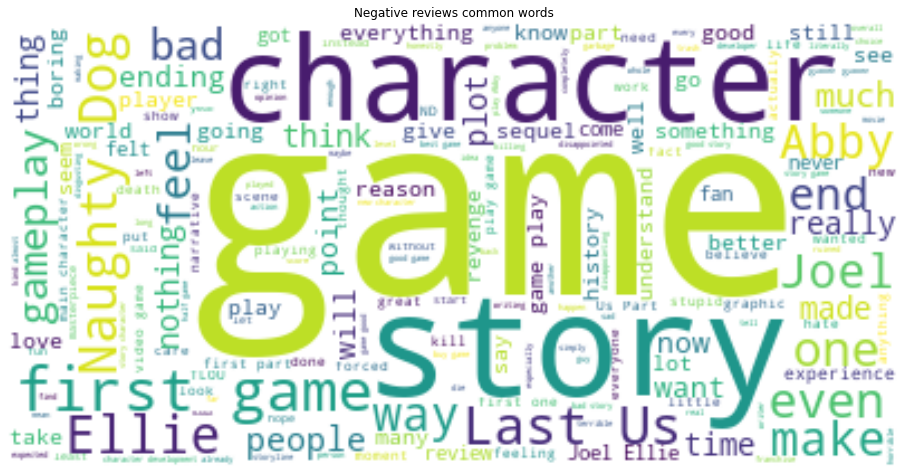

In [ ]:
show_word_cloud(negative_reviews_cloud, "Negative reviews common words")

Average review WordCloud

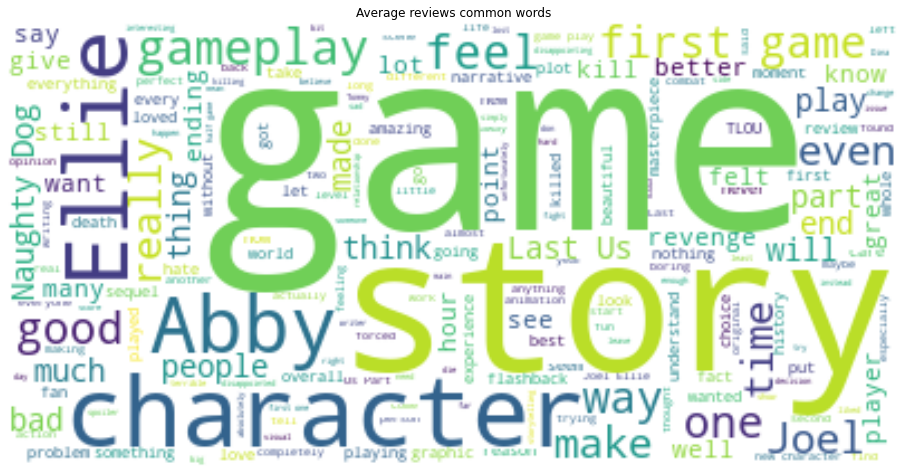

In [ ]:
show_word_cloud(average_reviews_cloud, "Average reviews common words")

Positive review WordCloud

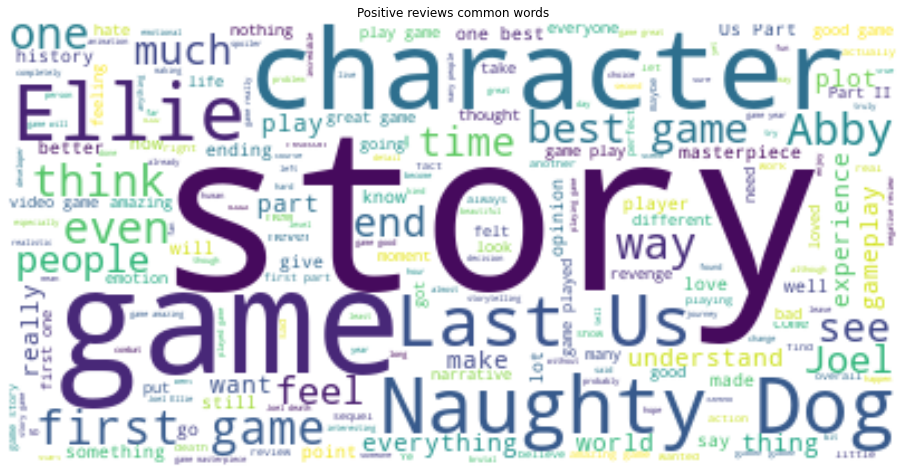

In [ ]:
show_word_cloud(positive_reviews_cloud, "Positive reviews common words")

# Embeddings 

Load the Universal Sentence Encoder

In [ ]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Want reviews to be the same shape as the previous embedder used when making models, so we change the shape from (31309,1) to (31309, 0)

In [ ]:
TLOU_reviews = pd.DataFrame(df['review'])
print(df['review'])
print(TLOU_reviews.shape)
TLOU_reviews = np.array(TLOU_reviews)
print(TLOU_reviews)
TLOU_reviews = np.reshape(TLOU_reviews, (31309, ))
print(TLOU_reviews.shape)


0        Technical part is amazing! Shadows, light awes...
1        Somewhere in this mess was potential for a gre...
2        i was so hyped for this game 20 and something ...
3        I do not think, a very dead Joel does not make...
4        What is this garbage. There is no game in ther...
                               ...                        
31304    Been playing the game for about a week now and...
31305    The story diversion and is no longer the magni...
31306    6/10, if he had put more interest to the story...
31307    Nothing describes this game better than disapp...
31308                             this game is pure trash.
Name: review, Length: 31309, dtype: object
(31309, 1)
[['Technical part is amazing! Shadows, light awesome.But story, so so so bad..']
 ['Somewhere in this mess was potential for a great story, but unfortunately it is bogged down by unnecessary side plots and baffling character choices.  Unfortunately, the graphics are not enough to save this game f

Create Embeddings for TLOU2 reviews:

In [ ]:
tlou_emb = []
for r in tqdm(TLOU_reviews):
  emb = use([r])
  review_emb = tf.reshape(emb, [-1]).numpy()
  tlou_emb.append(review_emb)

tlou_emb = np.array(tlou_emb)

100%|██████████| 31309/31309 [01:40<00:00, 312.23it/s]


Saving the embeddings:

In [ ]:
tlou_out = open("tlou.pickle","wb")
pickle.dump(tlou_emb, tlou_out)
tlou_out.close()

Load embeddings:

In [ ]:
pickle_in = open("drive/My Drive/tlou.pickle","rb")
tlou_emb = pickle.load(pickle_in)

In [ ]:
print(tlou_emb.shape)

# Predictions

Loading in Amazon Model

In [ ]:
model_A = keras.models.load_model("drive/My Drive/AmazonModel.h5")

Loading in Metacritic Model

In [ ]:
model_M = keras.models.load_model("drive/My Drive/MetacriticModel.h5")

Analysis

In [ ]:
print(df.iloc[5])
print("")
print(TLOU_reviews[5])

rating                                                         3
review         Jesus, where do I even begin. On a technical l...
review_type                                             Negative
Name: 5, dtype: object

Jesus, where do I even begin. On a technical level, this is Naughty Dog's best game. The graphics are amazing and the gameplay is buttery smooth. I do wish the jump button was used in a more interesting way. The combat feels mostly the same with new additions like the silencer that I enjoyed the most. I feel that upgrades for guns and abilities have been done better in this game too. Environments feel more real and they were a blast to play through. Those were my only positives sadly. I played this game on hard and god damn is this AI bad, absolutely no strides forward since 2013 and I had to check a few times to see if the difficulty switched to easy or something. And the story, I hated every second of it. The reason that I fell in love with the first game was because o

Negative ratings are left, average in the middle, positive to the right

In [ ]:
preda = model_A.predict(tlou_emb[4:5])
predb = model_M.predict(tlou_emb[4:5])
print(preda)
print(predb)

[[9.8945767e-01 1.0395249e-02 1.4706321e-04]]
[[0.10265941 0.8436737  0.05366689]]


print predictions for each review:

Go through each element of the embeddings and apply the appropriate model, appending each one to a list so that they can then have seperate columns in the dataframe. 

In [ ]:
ratingA = []
ratingA.append("Positive")
for i in tqdm(range (1,31309,1)):
  pred = model_A.predict(tlou_emb[i:i+1])
  if pred[0][0] > 0.33:
    ratingA.append("Negative")
  elif pred[0][1] > 0.33:
    ratingA.append("Average")
  else:
    ratingA.append("Positive")

100%|██████████| 31308/31308 [22:40<00:00, 23.02it/s]


In [ ]:
ratingM = []
ratingM.append("Positive")
for i in tqdm(range (1,31309,1)):
  pred = model_M.predict(tlou_emb[i:i+1])
  if pred[0][0] > 0.33:
    ratingM.append("Negative")
  elif pred[0][1] > 0.33:
    ratingM.append("Average")
  else:
    ratingM.append("Positive")

100%|██████████| 31308/31308 [21:55<00:00, 23.80it/s]


Add the new columns to the dataframe to compare:

In [ ]:
df["AmazonReviewType"] = ratingA
df["MetacriticReviewType"] = ratingM

print(df)

       rating                                             review  ... biasA biasM
0         2.0  Technical part is amazing! Shadows, light awes...  ...     1     1
1         2.0  Somewhere in this mess was potential for a gre...  ...     0     0
2         4.0  i was so hyped for this game 20 and something ...  ...     0     1
3         0.0  I do not think, a very dead Joel does not make...  ...     0     1
4         0.0  What is this garbage. There is no game in ther...  ...     0     1
...       ...                                                ...  ...   ...   ...
31304    10.0  Been playing the game for about a week now and...  ...     1     0
31305     1.0  The story diversion and is no longer the magni...  ...     0     1
31306     6.0  6/10, if he had put more interest to the story...  ...     0     1
31307     4.0  Nothing describes this game better than disapp...  ...     0     1
31308     0.0                           this game is pure trash.  ...     0     1

[31309 rows x 7



*   0: no bias 
*   1: potential bias



In [ ]:
df['biasA'] = np.where(df['review_type'] == df['AmazonReviewType'], 0, 1)
df['biasM'] = np.where(df['review_type'] == df['MetacriticReviewType'], 0, 1)
print(df)

       rating                                             review  ... biasA biasM
0         2.0  Technical part is amazing! Shadows, light awes...  ...     1     1
1         2.0  Somewhere in this mess was potential for a gre...  ...     0     0
2         4.0  i was so hyped for this game 20 and something ...  ...     0     1
3         0.0  I do not think, a very dead Joel does not make...  ...     0     1
4         0.0  What is this garbage. There is no game in ther...  ...     0     1
...       ...                                                ...  ...   ...   ...
31304    10.0  Been playing the game for about a week now and...  ...     1     0
31305     1.0  The story diversion and is no longer the magni...  ...     0     1
31306     6.0  6/10, if he had put more interest to the story...  ...     0     1
31307     4.0  Nothing describes this game better than disapp...  ...     0     1
31308     0.0                           this game is pure trash.  ...     0     1

[31309 rows x 7




*   41% of these reviews have potential bias from the Amazon model. 
*   52% of these reviews have potential bias from the Metacritic model.





In [ ]:
print(df['biasA'].value_counts())
print(df['biasM'].value_counts())

0    18507
1    12802
Name: biasA, dtype: int64
1    16349
0    14960
Name: biasM, dtype: int64


We save the new dataframe:

In [ ]:
df.to_csv("drive/My Drive/csv's/BiasDatasets/TLOUBias.csv")

Load the new dataframe:

In [ ]:
df = pd.read_csv("drive/My Drive/csv's/BiasDatasets/TLOUBias.csv")
print(df)
print(list(df))
del df['Unnamed: 0']
print(list(df))

       Unnamed: 0  rating  ... biasA biasM
0               0     2.0  ...     1     1
1               1     2.0  ...     0     0
2               2     4.0  ...     0     1
3               3     0.0  ...     0     1
4               4     0.0  ...     0     1
...           ...     ...  ...   ...   ...
31304       31304    10.0  ...     1     0
31305       31305     1.0  ...     0     1
31306       31306     6.0  ...     0     1
31307       31307     4.0  ...     0     1
31308       31308     0.0  ...     0     1

[31309 rows x 8 columns]
['Unnamed: 0', 'rating', 'review', 'review_type', 'AmazonReviewType', 'MetacriticReviewType', 'biasA', 'biasM']
['rating', 'review', 'review_type', 'AmazonReviewType', 'MetacriticReviewType', 'biasA', 'biasM']


Seperate the reviews so that any kind of bias detection in both models is in a dataframe. Here 22138/31309 detections of bias were found for TLOU2 dataset with the two different models. This implies 71% of the reviews have potential bias if we are using the two models together (i.e. 1 and 1, 1 and 0, 0 and 1). 

In [ ]:
df_bias1 = df[(df['biasA']==1)|(df['biasM']==1)].reset_index(drop=True)
print(df_bias1)

       rating                                             review  ... biasA biasM
0         2.0  Technical part is amazing! Shadows, light awes...  ...     1     1
1         4.0  i was so hyped for this game 20 and something ...  ...     0     1
2         0.0  I do not think, a very dead Joel does not make...  ...     0     1
3         0.0  What is this garbage. There is no game in ther...  ...     0     1
4         0.0  Nope! Nope! Nope! What a way to end the franch...  ...     0     1
...       ...                                                ...  ...   ...   ...
22133    10.0  Been playing the game for about a week now and...  ...     1     0
22134     1.0  The story diversion and is no longer the magni...  ...     0     1
22135     6.0  6/10, if he had put more interest to the story...  ...     0     1
22136     4.0  Nothing describes this game better than disapp...  ...     0     1
22137     0.0                           this game is pure trash.  ...     0     1

[22138 rows x 7

# Only Amazon model detects bias:

20 reviews starting from index 10 will be looked at, and then out of these it will be decided manually whether they are good decisions. 

In [ ]:
df_bias1a = df[(df['biasA']==1)&(df['biasM']==0)].reset_index(drop=True)
print(df_bias1a)

      rating                                             review  ... biasA biasM
0        4.0  I highly anticipated this game. I think to thi...  ...     1     0
1        6.0  One of the most disappointing sequels in video...  ...     1     0
2        0.0  disappointing plot and game play experience. N...  ...     1     0
3        0.0  Good music, great visual style. The average ga...  ...     1     0
4        0.0  Good graphics, but story and gameplay outdated...  ...     1     0
...      ...                                                ...  ...   ...   ...
5784    10.0  It is a **** incredible game and I don't under...  ...     1     0
5785     9.0  A narrative level does not become as round as ...  ...     1     0
5786    10.0  The Last of us 2 is definitely the game of the...  ...     1     0
5787    10.0  So good!! I don’t know why anyone would vote i...  ...     1     0
5788    10.0  Been playing the game for about a week now and...  ...     1     0

[5789 rows x 7 columns]


1) **Incorrect Detection:**

In [ ]:
print(df_bias1a.iloc[10])
print(df_bias1a.iloc[10,1])

rating                                                                  0
review                  The story was horrific even though the gamepla...
review_type                                                      Negative
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   0
Name: 10, dtype: object
The story was horrific even though the gameplay was barely decent.


2) **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[11])
print(df_bias1a.iloc[11,1])

rating                                                                  5
review                  Big disappointment. Part 1 was a great game. S...
review_type                                                       Average
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   0
Name: 11, dtype: object
Big disappointment. Part 1 was a great game. Stupid plot, clearly more focused on their own agenda instead of making a great game for gamers.


3) **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[12])
print(df_bias1a.iloc[12,1])

rating                                                                  5
review                  This game is a disgrace to the previous instal...
review_type                                                       Average
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   0
Name: 12, dtype: object
This game is a disgrace to the previous installation. Disgusting narrative!


4) **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[13])
print(df_bias1a.iloc[13,1])

rating                                                                  5
review                  This is a disgusting game that spoils the memo...
review_type                                                       Average
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   0
Name: 13, dtype: object
This is a disgusting game that spoils the memories of the beautiful first part with its feminist and inclinations. Awful gameplay, bad graphics and nasty plot. All this on ps4. How could a great company fall so low?


5)  **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[14])
print(df_bias1a.iloc[14,1])

rating                                                                  6
review                  Only good part is the museum sceneEllie's birt...
review_type                                                       Average
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   0
Name: 14, dtype: object
Only good part is the museum sceneEllie's birthday partStory 0/10So sad so sad


6)  **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[15])
print(df_bias1a.iloc[15,1])

rating                                                                  0
review                  Some problems with NPC, and big thanks for Ani...
review_type                                                      Negative
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   0
Name: 15, dtype: object
Some problems with NPC, and big thanks for Anita. And personally, I didn't enjoy the main story


7) **Correct Detection:** Only negative things said about the game

In [ ]:
print(df_bias1a.iloc[16])
print(df_bias1a.iloc[16,1])

rating                                5
review                  Stupid story  -
review_type                     Average
AmazonReviewType               Negative
MetacriticReviewType            Average
biasA                                 1
biasM                                 0
Name: 16, dtype: object
Stupid story  -


8)  **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[17])
print(df_bias1a.iloc[17,1])

rating                                                                  6
review                  It's funny that they were putting so much effo...
review_type                                                       Average
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   0
Name: 17, dtype: object
It's funny that they were putting so much effort to be political correct and don't really care if the whole thing makes sense or not


9) **Incorrect Detection:** 

In [ ]:
print(df_bias1a.iloc[18])
print(df_bias1a.iloc[18,1])

rating                                                                  2
review                  The problem with this game is that Naughty Dog...
review_type                                                      Negative
AmazonReviewType                                                 Positive
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   0
Name: 18, dtype: object
The problem with this game is that Naughty Dog tries catering towards the LGBTQ community and abandoning it's core values and fans that made this first part so great. I will start with the good aspects. The graphics are unmatched, the best the PS4 has to offer. The AI, the choreography are top notch. The gameplay is very enjoyable. For these aspects I will give it a 4/10. Sadly TLOU2 is a story based game which means it needs a good story for it to succe

10) **Incorrect Detection:** 

In [ ]:
print(df_bias1a.iloc[19])
print(df_bias1a.iloc[19,1])

rating                                                                  5
review                  We wanted a sequel to The Last of Us and got a...
review_type                                                       Average
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   0
Name: 19, dtype: object
We wanted a sequel to The Last of Us and got a great game in terms of graphics and gameplay and disgusting in terms of plot


11) **Incorrect Detection:** 

In [ ]:
print(df_bias1a.iloc[20])
print(df_bias1a.iloc[20,1])

rating                                                                  5
review                  If you asked the giraffe from the first game t...
review_type                                                       Average
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   0
Name: 20, dtype: object
If you asked the giraffe from the first game to write the sequel, it would've probably written better story than this. I'm giving 5 just for the artists/devs efforts who made this horrible thing somewhat bearable


12) **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[21])
print(df_bias1a.iloc[21,1])

rating                                                                  5
review                  Played it for the story. I couldn't be more di...
review_type                                                       Average
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   0
Name: 21, dtype: object
Played it for the story. I couldn't be more disappointed! Don't want to play it a second time, so I sold it....


13) **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[22])
print(df_bias1a.iloc[22,1])

rating                                                                  0
review                  Technical part is amazing! Shadows, light awes...
review_type                                                      Negative
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   0
Name: 22, dtype: object
Technical part is amazing! Shadows, light awesome.But scenario, so so so bad..


14) **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[23])
print(df_bias1a.iloc[23,1])

rating                                                                  1
review                  story 1, this part has got a very high rate fr...
review_type                                                      Negative
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   0
Name: 23, dtype: object
story 1, this part has got a very high rate from media, but in fact its really a ****
graphic 7, there are many details, but it's not better than Uncharted 4
music 4
gameplay 4, it's almost same as 1, no big improving and playing the guitar is boring
Such a long wait is not worth it :(


15) **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[24])
print(df_bias1a.iloc[24,1])

rating                                                                  4
review                  Running after a fashionable trend, the develop...
review_type                                                      Negative
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   0
Name: 24, dtype: object
Running after a fashionable trend, the developers forgot about the plot-casting, which should move the plot to not degrade with great progression!  Yes, the graphics in the game are beautiful and detailed!  but you won’t leave it alone, the game is very lightweight even at a high level of difficulty it didn’t impress me, the mechanics of the game are also too primitive, I really looked forward to its evolution, but it didn’t work out, so my rating is onl

16) **Correct Detection:** 

In [ ]:
print(df_bias1a.iloc[25])
print(df_bias1a.iloc[25,1])

rating                                                                 10
review                  Every game has some minor issues, this is VERY...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                             Positive
biasA                                                                   1
biasM                                                                   0
Name: 25, dtype: object
Every game has some minor issues, this is VERY far from the worst game I've ever played, and yes while I believed the decision to play as Abby several times was a most peculiar choice. One that at first I did not completely agree with, but after completing the game, I really do feel for and understand both Ellie and Abbie's perspectives. The gameplay and graphics really stand out 10/10 for that BUT, while some of the story choices can feel odd at times. 

17) **Incorrect Detection:** 

In [ ]:
print(df_bias1a.iloc[26])
print(df_bias1a.iloc[26,1])

rating                                                                 10
review                  Stop with the false narrative: There isn't a s...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                             Positive
biasA                                                                   1
biasM                                                                   0
Name: 26, dtype: object
Stop with the false narrative: There isn't a strong divide between players, as the user score makes it seem. Most people who have ACTUALLY played and finished the game, like it. This game was heavily review bombed.
Isn't it ironic that a game about "hate" does garners so much of it from immature people, who seemingly feel unmasked by this game? Isn't it ironic that poor Neil Druckmann gets all the blame, even though HE wrote the first game (TLOU) ON HIS 

18) **Incorrect Detection:** 

In [ ]:
print(df_bias1a.iloc[27])
print(df_bias1a.iloc[27,1])

rating                                                                 10
review                  Absolutely amazing. Gameplay is way better tha...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Positive
biasA                                                                   1
biasM                                                                   0
Name: 27, dtype: object
Absolutely amazing. Gameplay is way better than TLOU 1 and the atmosphere and storytelling is stellar. This kind of cinematic experience is rivaled only by Rockstar's RDR2.


19) **Incorrect Detection:** 

In [ ]:
print(df_bias1a.iloc[28])
print(df_bias1a.iloc[28,1])

rating                                                                 10
review                  I'll start off by saying this game is not for ...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Positive
biasA                                                                   1
biasM                                                                   0
Name: 28, dtype: object
I'll start off by saying this game is not for the light of heart and it will challenge you against conventional storytelling. Its uncomfortable,overwhelming and challenging. Its bleak more often than not but when it wraps its truly masterful storytelling. The gameplay is top notch. The graphics are unlike anything I've seen.


20) **Incorrect Detection:** 

In [ ]:
print(df_bias1a.iloc[29])
print(df_bias1a.iloc[29,1])

rating                                                                 10
review                  Very good game, excellent playability, excelle...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Positive
biasA                                                                   1
biasM                                                                   0
Name: 29, dtype: object
Very good game, excellent playability, excellent graphics taking full power of a limited console that is the PS4, history is good must have an open mind, say no to the hate. Gorgeous this game


12/20 of the games examined manually are actually biased (60% accurate). 

# Only Metacritic model detects bias

In [ ]:
df_bias1b = df[(df['biasA']==0)&(df['biasM']==1)].reset_index(drop=True)
print(df_bias1b)

      rating                                             review  ... biasA biasM
0        4.0  i was so hyped for this game 20 and something ...  ...     0     1
1        0.0  I do not think, a very dead Joel does not make...  ...     0     1
2        0.0  What is this garbage. There is no game in ther...  ...     0     1
3        0.0  Nope! Nope! Nope! What a way to end the franch...  ...     0     1
4        2.0  False adverting with the plot, Naughty dog com...  ...     0     1
...      ...                                                ...  ...   ...   ...
9331     1.0  This game is a disgrace, just like anyone defe...  ...     0     1
9332     1.0  The story diversion and is no longer the magni...  ...     0     1
9333     6.0  6/10, if he had put more interest to the story...  ...     0     1
9334     4.0  Nothing describes this game better than disapp...  ...     0     1
9335     0.0                           this game is pure trash.  ...     0     1

[9336 rows x 7 columns]


1) **Incorrect Detection:** 

In [ ]:
print(df_bias1b.iloc[1])
print(df_bias1b.iloc[1,1])

rating                                                                  0
review                  I do not think, a very dead Joel does not make...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 1, dtype: object
I do not think, a very dead Joel does not make sense, quite abruptly, follow Allie very lightly give up revenge, which makes no sense to follow the story front. Moreover, there is too much political correctness, causing the game overall is very hypocritical!


2) **Incorrect Detection:** 

In [ ]:
print(df_bias1b.iloc[2])
print(df_bias1b.iloc[2,1])

rating                                                                  0
review                  What is this garbage. There is no game in ther...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 2, dtype: object
What is this garbage. There is no game in there. Just a number of different agendas they tried their best to show.


3) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[3])
print(df_bias1b.iloc[3,1])

rating                                                                  0
review                  Nope! Nope! Nope! What a way to end the franch...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 3, dtype: object
Nope! Nope! Nope! What a way to end the franchise...in the first 2 hours of the game.


4) **Incorrect Detection:** 

In [ ]:
print(df_bias1b.iloc[4])
print(df_bias1b.iloc[4,1])

rating                                                                  2
review                  False adverting with the plot, Naughty dog com...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 4, dtype: object
False adverting with the plot, Naughty dog completely disregarded what people liked about the first game and instead shoveled out this trash, On top of that the crunch time game dev's at Naughty dog had to experience is inhumane just to finish the game.


5) **Incorrect Detection:** 

In [ ]:
print(df_bias1b.iloc[6])
print(df_bias1b.iloc[6,1])

rating                                                                  0
review                  The plot of the game is terrible and totally u...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 6, dtype: object
The plot of the game is terrible and totally unacceptable. A mandatory ending that doesn't give the player a choice.


6) **Incorrect Detection:** 





In [ ]:
print(df_bias1b.iloc[7])
print(df_bias1b.iloc[7,1])

rating                                                                  1
review                  Worst story ever. Naughty dog should be ashame...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 7, dtype: object
Worst story ever. Naughty dog should be ashamed of themselves,the last of us 1 was a Masterpiece.....part 2 pure trash


7) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[8])
print(df_bias1b.iloc[8,1])

rating                                                                  4
review                  Incredible visuals and music can't make up for...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 8, dtype: object
Incredible visuals and music can't make up for a complete lack of skill in writing. The story is unbelievable, full of plot holes, often depraved in failed attempts at adding shock factor and spits on the legacy of the original. A painful game to experience.
 It is further insult to injury that Naughty Dog used false advertising to sell the game to fans of the first.


8) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[9])
print(df_bias1b.iloc[9,1])

rating                                                                  0
review                  Such a huge disappointment after years of wait...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 9, dtype: object
Such a huge disappointment after years of waiting.


9) **Correct Detection:**

In [ ]:
print(df_bias1b.iloc[10])
print(df_bias1b.iloc[10,1])

rating                                                                  0
review                  I was waiting for a masterpiece, but got one o...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 10, dtype: object
I was waiting for a masterpiece, but got one of the worst games. “The Last of Us” was one of the best games I played, the plot of “The Last of Us 2” is one of the most disgusting, it seems, the developers decided to spoil what they created. They took and killed one of the protagonists of the first part of the game, and put another in his place. It’s better to eliminate the heroine herself or her friend ...
I am sorry for the money spent on this game.
Cur

10) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[11])
print(df_bias1b.iloc[11,1])

rating                                                                  0
review                  Complete utter fecal matter. Story was literal...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 11, dtype: object
Complete utter fecal matter. Story was literal garbage and the developers made sure to piss off all the fans. DO NOT BUY.


11) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[12])
print(df_bias1b.iloc[12,1])

rating                                                                  0
review                  This I did not expect! The second half of the ...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 12, dtype: object
This I did not expect! The second half of the game, where for Abby - it's a nightmare. Sorry for the time spent.


12) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[13])
print(df_bias1b.iloc[13,1])

rating                                                                  0
review                  This is an absolute abomination. They butchere...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 13, dtype: object
This is an absolute abomination. They butchered the story and it is clear character assassination, Joel is nothing like he was in the first game, makes a very stupid and out of character mistake that real Joel would never do. They went for shock value... so many disgusting scenes. The graphics are downgraded compared what they originally showed and the gameplay is still mediocre, this product has nothing to offer.


13) **Correct Detection:**

In [ ]:
print(df_bias1b.iloc[14])
print(df_bias1b.iloc[14,1])

rating                                                                  1
review                  Notorious technical achievement and great acce...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 14, dtype: object
Notorious technical achievement and great accessibility for gamers that is to be applauded. But its core, the story; it's poorly written, it just wants you to swallow it without questioning the obviousness of its shortcomings. It is sad, because after a first delivery full of love and with a message more than charming, comes this new delivery to ruin everything established to bring something more than pretentious. A pity, really.


14) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[15])
print(df_bias1b.iloc[15,1])

rating                                                                  2
review                  "Subverting expectations" by making the game u...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 15, dtype: object
"Subverting expectations" by making the game unenjoyable from the plot point standard, doing a disservice to the entirety of TLOU 1 that was written by leagues more competent writers and doing all of that to pander to people that don't even play videogames is exactly how not to make a videogame, let alone a huge budget project that is supposed to be the killer app of the generation. Even ignoring all of that, which is absolutely impossible due to the gam

15) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[16])
print(df_bias1b.iloc[16,1])

rating                                                                  1
review                  So, You kill 100-150 people as Ellie, just to ...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 16, dtype: object
So, You kill 100-150 people as Ellie, just to get to the end, and you are forced to decide not to kill Abby, because... and I kid you not, "killing people is wrong"?  I mean, you'd think, hey a writer can't be this stupid.  Sadly, you'd be wrong.


16) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[17])
print(df_bias1b.iloc[17,1])

rating                                                                  0
review                  A spit in the face of the original. Nonsensica...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 17, dtype: object
A spit in the face of the original. Nonsensical narrative and a total disregard for beloved characters, how did this make it to print?


17) **Correct Detection:**

In [ ]:
print(df_bias1b.iloc[18])
print(df_bias1b.iloc[18,1])

rating                                                                  0
review                  you know one advantage that tlou 2 has is that...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                             Positive
biasA                                                                   0
biasM                                                                   1
Name: 18, dtype: object
you know one advantage that tlou 2 has is that it has good graphics other than that story, game mechanics, etc. it is bad. you build Joel in the first game to never trust a stranger then suddenly he trusted and give his name to a bunch of strangers like what is that **** storytelling.


18) **Correct Detection:**

In [ ]:
print(df_bias1b.iloc[19])
print(df_bias1b.iloc[19,1])

rating                                                                  1
review                  Ugh. The visuals are about the only thing this...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 19, dtype: object
Ugh. The visuals are about the only thing this game offers. The story writers must have phoned in this game, or been replaced since it ends up being less a fun sequel to a great game, and more a 10 hour long commercial for whatever agendas they want to push.I'm hoping this is the last of the series after playing this mess.


19) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[20])
print(df_bias1b.iloc[20,1])

rating                                                                  4
review                  Petty revenge plot with spontaneous forgivenes...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 20, dtype: object
Petty revenge plot with spontaneous forgiveness at the end after hundred killings. Below average.


20) **Incorrect Detection:**

In [ ]:
print(df_bias1b.iloc[21])
print(df_bias1b.iloc[21,1])

rating                                                                  0
review                  this game butchers everything the first game w...
review_type                                                      Negative
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   0
biasM                                                                   1
Name: 21, dtype: object
this game butchers everything the first game was about. the story is highly illogical and makes no sense by the end. do not waste your money


Only 4/20 (20%) of the games detected bias correctly through manually checking

# Both models detect bias:

It was much harder to find correctly detected bias in the Metacrtic Model predictions when the Amazon model did not detect bias, therefore below are the results for when both models detect bias. 

In [ ]:
df_bias2 = df[(df['biasA']==1)&(df['biasM']==1)].reset_index(drop=True)
print(df_bias2)

      rating                                             review  ... biasA biasM
0        2.0  Technical part is amazing! Shadows, light awes...  ...     1     1
1        4.0  Visuals are great, gameplay is really similar ...  ...     1     1
2        0.0  If I had a choice between this game or Knack 2...  ...     1     1
3        7.0  All I'm going to say is, what were they thinki...  ...     1     1
4        5.0  A game that was handcrafted so you can fell ba...  ...     1     1
...      ...                                                ...  ...   ...   ...
7008    10.0  AM GIVING MY 10 HERE PQ IF I DER UNLESS IT OR ...  ...     1     1
7009     9.0  I liked it, but I expected more. The story sur...  ...     1     1
7010    10.0  It's not the story that those who played the f...  ...     1     1
7011     5.0  There gameplay is smooth as butter, the visual...  ...     1     1
7012    10.0  naughty think if most people don't like this g...  ...     1     1

[7013 rows x 7 columns]


1) **Correct Detection:**

In [ ]:
print(df_bias2.iloc[40])
print(df_bias2.iloc[40,1])

rating                                                                 10
review                  The game has some things some choices that it ...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 40, dtype: object
The game has some things some choices that it does that it takes, that it’s not that good or good overall but those things don’t ruin the game or don’t make the story bad...Yes Joel dying near the beginning could have been at least at the second act of the game and I’m pissed because it was near the beginning but it is what it is.Also the way Joel died people have to let this go this is TLOU world did you even play the first one all deaths were brutal an

2) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[41])
print(df_bias2.iloc[41,1])

rating                                                                  8
review                  The story is something different than the firs...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 41, dtype: object
The story is something different than the first game. The game is incredible, the characters are just amazing. The gameplay is better than the first game. I see why people are mad and that is understandable. The game is hard to consume it's just depressing ,but that is what makes it really good.


3) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[42])
print(df_bias2.iloc[42,1])

rating                                                                 10
review                  Loved the Game.\n The Gameplay was fun, even w...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 42, dtype: object
Loved the Game.
 The Gameplay was fun, even when it was brutal.
 The Graphics are fantastic, especially the landscape and environment is engaging.
 I dont need to talk much about the story. what i liked the most is that ND dared to go to routs which no other Videogame till today took. It trys to tell a dark story on the scales of many Movies and Series.
 Its a pity that many Gamers cant play a game where actions have repercussions, where other characters

4) **Correct Detection:**

In [ ]:
print(df_bias2.iloc[43])
print(df_bias2.iloc[43,1])

rating                                                                 10
review                  Don't listen to all the negative user reviews ...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   1
Name: 43, dtype: object
Don't listen to all the negative user reviews - they haven't even played the game.


5) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[44])
print(df_bias2.iloc[44,1])

rating                                                                 10
review                  Do not heed the bad reviews and spoilers, a ve...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   1
Name: 44, dtype: object
Do not heed the bad reviews and spoilers, a very good game, Joel wish had not died.


6) **Correct Detection:**

In [ ]:
print(df_bias2.iloc[45])
print(df_bias2.iloc[45,1])

rating                                                                 10
review                  Naughty Dog successfully pushes the envelope o...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 45, dtype: object
Naughty Dog successfully pushes the envelope on games as a narrative medium further than anyone has done before. While perspective shifts are a common trick in movies and games, rarely has it been done so effectively and impactfully as in this game. Hands down the story is the best part of this game. Everything just makes complete sense in the context of the game's universe and how events unfold.
 Arguably it is actually on the gameplay mechanics front t

7) **Correct Detection:**

In [ ]:
print(df_bias2.iloc[46])
print(df_bias2.iloc[46,1])

rating                                                                  9
review                  It's inferior to its predecessor, with some SJ...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 46, dtype: object
It's inferior to its predecessor, with some SJW / Progressive **** But overall, it's a good game, worth at least a single play through. Graphically good, gameplay is nice. Story and narrative are inferior to the first game but overall it's not as bad as it seems. The ending could have been better if the player was given choice. But it makes sense considering everything that happened.


8) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[47])
print(df_bias2.iloc[47,1])

rating                                                                 10
review                  The combat and gameplay were excellent. Story ...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   1
Name: 47, dtype: object
The combat and gameplay were excellent. Story was a tiny bit long but nothing to warrant this nerd / fanboy / fan girl rage is amusing... Loved it... keep crying nerds


9) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[48])
print(df_bias2.iloc[48,1])

rating                                                                 10
review                  Graphics, gameplay, story. It’s a masterpiece,...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   1
Name: 48, dtype: object
Graphics, gameplay, story. It’s a masterpiece, plain and simple. The themes in this game build and expand upon its prequel in ways that don’t resort to trope. We’ve all over-analyzed the first game, and this game seems to leave us with questions we didn’t think to ask before.


10) **Correct Detection:**

In [ ]:
print(df_bias2.iloc[49])
print(df_bias2.iloc[49,1])

rating                                                                  9
review                  I know games should give a meaningful message ...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 49, dtype: object
I know games should give a meaningful message but it SHOULD make us feel good as well about the ending at least. This said, it's a great game with amazing graphics, good gameplay and voice acting. However, it'd have been better if Ellie had some material gain rather than just losing her father figure, her friends, her GF, her fingers and her mother's knife. Maybe that's why I thought she should've killed Abby to get some kind of


11) **Correct Detection:**

In [ ]:
print(df_bias2.iloc[50])d
print(df_bias2.iloc[50,1])

rating                                                                  8
review                  Good game, good graphics, good gameplay, great...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 50, dtype: object
Good game, good graphics, good gameplay, great interface but q story is weak


12) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[51])
print(df_bias2.iloc[51,1])

rating                                                                 10
review                  Amazing game. leaks were fake graphics are hot...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   1
Name: 51, dtype: object
Amazing game. leaks were fake graphics are hot af i love this game


13) **Correct Detection:**

In [ ]:
print(df_bias2.iloc[52])
print(df_bias2.iloc[52,1])

rating                                                                 10
review                  The game seemed excellent, good plot, good gra...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   1
Name: 52, dtype: object
The game seemed excellent, good plot, good graphics, good story (mostly the abby), the only thing to criticize is that fanaticism constantly mention how lesbian ellie, and did not see the need for trans Lev, too liberal in that regard on unnecessary things, but you can not deny that removing it is a very good game.


14) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[53])
print(df_bias2.iloc[53,1])

rating                                                                 10
review                  The Last Of Us 2 is a masterpiece in every sen...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 53, dtype: object
The Last Of Us 2 is a masterpiece in every sense of the word. Putting aside all the representation of the LGBTQ and what not, I feel that that's is just how the story was presented with and shouldn't be used as a reason to hate it. Instead I will be focusing on the gameplay and of course the Story that everyone hate for god knows what reason.
 Gameplay wise, it's amazing. It was improved in every sense from the first game, allowing me to play to my style

15) **Correct Detection:** says it is a 9/10 and leaves a 10/10 score

In [ ]:
print(df_bias2.iloc[54])
print(df_bias2.iloc[54,1])

rating                                                                 10
review                  I was fortunate enough to avoid the leaked spo...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 54, dtype: object
I was fortunate enough to avoid the leaked spoilers and fully experience the game start to finish without any external knowledge of the polt's events or the opinions of others. So when I came online to discuss the game with others, I was surprised to see how much negative noise it was receiving. If you have been exposed to spoilers, I implore you to keep an open mind and play the game start to finish anyway. Anyone who plays the game with the ability to 

16) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[55])
print(df_bias2.iloc[55,1])

rating                                                                 10
review                  The game is not bad if you do not have eë go i...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 55, dtype: object
The game is not bad if you do not have eë go if somewhere out there in the beginning proglyadyvaetya small agenda


17) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[56])
print(df_bias2.iloc[56,1])

rating                                                                 10
review                  amazing game, the quality of music, environmen...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                              Average
biasA                                                                   1
biasM                                                                   1
Name: 56, dtype: object
amazing game, the quality of music, environment.
Perhaps Joel's death is shocking, but it gives weight to the reason for the engine in the story.


18) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[57])
print(df_bias2.iloc[57,1])

rating                                                                 10
review                  Juegaso is not swayed by the bad reviews have ...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 57, dtype: object
Juegaso is not swayed by the bad reviews have incredible graphics the gameplay is great


19) **Incorrect Detection:**

In [ ]:
print(df_bias2.iloc[58])
print(df_bias2.iloc[58,1])

rating                                                                 10
review                  The game is amazing in all its aspects and the...
review_type                                                      Positive
AmazonReviewType                                                 Negative
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 58, dtype: object
The game is amazing in all its aspects and the story is very different from what is customary in big productions Hollywood.TLOU did not need a sequel, however this new release keeps up the franchise.


20) **Correct Detection:**

In [ ]:
print(df_bias2.iloc[59])
print(df_bias2.iloc[59,1])

rating                                                                 10
review                  I play really gone, yes, of course, not withou...
review_type                                                      Positive
AmazonReviewType                                                  Average
MetacriticReviewType                                             Negative
biasA                                                                   1
biasM                                                                   1
Name: 59, dtype: object
I play really gone, yes, of course, not without disadvantages. But in general - is a great product ..


9/20 (45%) reviews were actually biased. 

# Similar Reviews and Identical Reviews

I initially thought there was something wrong with my web scraping and changed it multiple times, however I came to realise that there were a number of reviews that were almost identical which could be a sign of bots:

------------------------------------------

*   "Technical part is amazing! Shadows, light awesome.But story, so so so bad.." 2/10
*   "Technical part is amazing! Shadows, light awesome.But scenario, so so so bad.." 0/10
*   "Technical part is amazing! Shadows, light awesome.
But... This is a spit in the face of the players of the first part. Shame." 1/10
*   "Technical part is amazing! Shadows, light awesome." 10/10

------------------------------------------




The following review was recorded 3 times with review scores 0,0,1. 

"Complete utter fecal matter. Story was literal garbage and the developers made sure to piss off all the fans. DO NOT BUY."




# Overall

When making predictions on The Last of Us dataset I noticed several things:
*   It was easier to find good bias detection with the Amazon model than Metacritic. This could be down to the fact that it was trained on 100,000s more reviews or the Metacritic model itself is trained on biased data. 
*   Using a combination of the two models was easier to find bias than Metacritic but worse than the Amazon model alone that were accurate, although it did not eliminate users aiming their sentiment towards other users or games. 
*   There were 22137/31309 detections of bias collectively, and we know that both models have around 70% accuracy. The Last of Us 2 has approximately 49% reviews with potential bias. 
*   As metacritic alone was not that accurate, we look at anywhere where Amazon detected bias, therefore 12801/31309 with 70% accuracy shows 29% bias. 
*   From these results I would assume that at least 1/4 of reviews for TLOU2 on Amazon are biased. 












